In [1]:
from learningAgent import LearningAlgorithm
from environment import Model, AdversaryModes
from Qtable import QTable
from test import Test
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
np.random.seed(11)

In [3]:
total_demand = 400
agent_cost = 57
adversary_cost = 71 
costs = [agent_cost,adversary_cost]
total_stages = 25
adversary_probabilities=[0]*len(AdversaryModes)
# Below is where we decide what adversaries we train against- see environment.py for the numbers
# Replace * and ** with the two number associated with the opponents at the bottom of environment.py
adversary_probabilities[10]= 0.5
adversary_probabilities[11] = 0.5
game = Model(total_demand, costs, total_stages, adversary_probabilities)

In [4]:
number_actions = 50
number_demands = total_demand + 1
discount_factor = 1
number_episodes = 10_000
constant = int(number_episodes/49)
print(constant)

204


In [5]:
# Learning rate is given as [numerator,denominator] which gives us a learning rate function of 
# numerator/(n+denominator)
Qtable = QTable(number_demands, number_actions, total_stages , learning_rate = [constant,constant])

In [6]:
algorithm = LearningAlgorithm(game, Qtable, number_episodes, discount_factor)

0 0.9457689764160323
Current payoff for adversary 1:  59620.0
Current payoff for adversary 2:  36087.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  53712.0
Current payoff for adversary 1:  12040.0
Current payoff for adversary 2:  2756.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  54176.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  54176.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  54176.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  51573.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  51573.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  51573.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  51298.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  51298.0
Current payoff for adversary 1:  89207.0
Current payoff for adversary 2:  5129

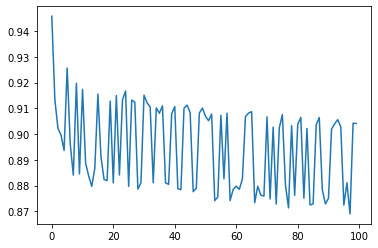

In [7]:
# Below is the first stage of learning- actions are chosen randomly.
number_episodes_per_round = 100
number_rounds = int(number_episodes / number_episodes_per_round)
errors = np.zeros(number_rounds)
final_round = 0
opponent1_results = list()
opponent2_results = list()
for round_ in range(number_rounds):
    algorithm.continue_learning(number_episodes_per_round,number_episodes_per_round * round_ +1)
    adversary_probabilities[10]= 0.5
    adversary_probabilities[11] = 0.5
    result = Test(game, Qtable, discount_factor, adversary_probabilities)
    errors[round_] = result.error(1000)
    if round_ % 50 == 0:
        print(round_, errors[round_])
    if round_ > 10 and np.max(errors[round_-10:round_]) < 0.5:
        print(round_)
        final_round = round_
        break
        
    adversary_probabilities=[0]*len(AdversaryModes)
    adversary_probabilities[10]=1
    result = Test(game, Qtable, discount_factor, adversary_probabilities)
    payoff1, adversary_payoff, actions, adversary_actions, demand_potential = result.total_payoff()
    opponent1_results.append(payoff1)
    print('Current payoff for adversary 1: ', payoff1)
    
    adversary_probabilities=[0]*len(AdversaryModes)
    adversary_probabilities[11]=1
    result = Test(game, Qtable, discount_factor, adversary_probabilities)
    payoff2, adversary_payoff, actions, adversary_actions, demand_potential = result.total_payoff()
    opponent2_results.append(payoff2)
    print('Current payoff for adversary 2: ', payoff2)
    
    if (round_ == number_rounds - 1):
        final_round = round_
    
plt.plot(errors[0:final_round+1])

In [8]:
print(errors)

[0.95 0.91 0.9  0.9  0.89 0.93 0.9  0.88 0.92 0.88 0.92 0.89 0.88 0.88
 0.89 0.92 0.89 0.88 0.88 0.91 0.88 0.91 0.88 0.91 0.92 0.88 0.91 0.91
 0.88 0.88 0.92 0.91 0.91 0.88 0.91 0.91 0.91 0.88 0.88 0.91 0.91 0.88
 0.88 0.91 0.91 0.91 0.88 0.88 0.91 0.91 0.91 0.91 0.91 0.87 0.88 0.91
 0.88 0.91 0.87 0.88 0.88 0.88 0.88 0.91 0.91 0.91 0.87 0.88 0.88 0.88
 0.91 0.87 0.9  0.87 0.9  0.91 0.88 0.87 0.9  0.88 0.9  0.91 0.88 0.9
 0.87 0.87 0.9  0.91 0.88 0.87 0.88 0.9  0.9  0.91 0.9  0.87 0.88 0.87
 0.9  0.9 ]


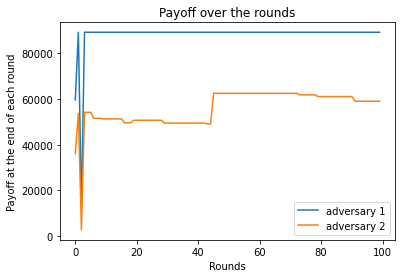

In [9]:
# Below is the second stage of learning- actions are chosen according to an epsilon greedy strategy.
episode_counter = (final_round + 1) * number_episodes_per_round
episodes_left = number_episodes - episode_counter
number_episodes_per_round = 500
number_rounds = int(episodes_left / number_episodes_per_round)

for round_ in range(number_rounds): 
    print('Round ', round_, ' of ', number_rounds)
    algorithm.epsilon_greedy_learning(number_episodes_per_round, episode_counter)
    
    adversary_probabilities=[0]*len(AdversaryModes)
    adversary_probabilities[10]=1
    result = Test(game, Qtable, discount_factor, adversary_probabilities)
    payoff1, adversary_payoff, actions, adversary_actions, demand_potential = result.total_payoff()
    opponent1_results.append(payoff1)
    print('Current payoff for adversary 1: ', payoff1)
    
    adversary_probabilities=[0]*len(AdversaryModes)
    adversary_probabilities[11]=1
    result = Test(game, Qtable, discount_factor, adversary_probabilities)
    payoff2, adversary_payoff, actions, adversary_actions, demand_potential = result.total_payoff()
    opponent2_results.append(payoff2)
    print('Current payoff for adversary 2: ', payoff2)
    
    episode_counter += number_episodes_per_round
    
plt.plot(opponent1_results)
plt.plot(opponent2_results)
plt.title("Payoff over the rounds")
plt.xlabel("Rounds")
plt.ylabel("Payoff at the end of each round")
legend = ["adversary 1", "adversary 2"]
plt.legend(legend)

In [10]:
Qtable.save("Qtable_guess132_guess128")

df1 = pd.DataFrame(opponent1_results)
df2 = pd.DataFrame(opponent2_results)

writer = pd.ExcelWriter('payoffs.xlsx', engine='xlsxwriter')
df1.to_excel(writer, sheet_name='payoff1', index=False)
df2.to_excel(writer, sheet_name='payoff2', index=False)
writer.save()

In [11]:
# We now have the trained agent. We want to test it against each opponent individually, so that
# we can compare it against the agent that is just trained against this opponent. 

In [12]:
adversary_probabilities=[0]*len(AdversaryModes)
# Testing against one type of opponent by changing the * below to be the first number
adversary_probabilities[10]=1
result = Test(game, Qtable, discount_factor, adversary_probabilities)
payoff, adversary_payoff, actions, adversary_actions, demand_potential = result.total_payoff()
print(payoff)
print(adversary_payoff)
print(actions)
print(adversary_actions)
print(demand_potential)

89207.0
75335.0
[114 109 131 104  91  95 110 106  89 116  90  95  92  93 112  92  88 115
  70  88 107  66  81 112 102]
[132 110 105 105 105 105  93  93  93  93  93  93  93  93  93  93  93  93
  93  93  93  93  93  93 146]
[200. 209. 209. 196. 196. 203. 208. 199. 192. 194. 182. 183. 182. 182.
 182. 172. 172. 174. 163. 174. 176. 169. 182. 188. 178.]


In [13]:
adversary_probabilities=[0]*len(AdversaryModes)
# Testing against one type of opponent by changing the * below to be the first number
adversary_probabilities[11]=1
result = Test(game, Qtable, discount_factor, adversary_probabilities)
payoff, adversary_payoff, actions, adversary_actions, demand_potential = result.total_payoff()
print(payoff)
print(adversary_payoff)
print(actions)
print(adversary_actions)
print(demand_potential)

59020.0
36736.0
[114 110 132 104  87  97  95  97  81 127  78 105 102  66  78  98  91  85
  81  78  76  74  72  71  22]
[125 125 100 100 100 100 100 100 100  69  69  69  69  69  69  69  69  69
  69  69  69  69  69  69 193]
[200. 205. 212. 196. 194. 200. 201. 203. 204. 213. 184. 179. 161. 144.
 145. 140. 125. 114. 106. 100.  95.  91.  88.  86.  85.]
